# Import cleaned data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:
FOLDER = 'data/'
data = pd.read_csv(FOLDER+'data.csv', low_memory=False)
data.head(10)

,date,county_name,state,subject_race,officer_race,search_conducted,contraband_found
0,2009-10-27,Walla Walla County,WA,white,white,False,NaN
1,2009-10-04,King County,WA,black,white,False,NaN
2,2009-10-04,Kittitas County,WA,white,white,False,NaN
3,2009-10-04,Clark County,WA,white,white,False,NaN
4,2009-10-11,Kitsap County,WA,white,white,False,NaN
5,2009-10-05,Skagit County,WA,white,white,False,NaN
6,2009-10-02,Pierce County,WA,black,white,False,NaN
7,2009-10-12,King County,WA,white,black,True,False
8,2009-10-04,Grays Harbor County,WA,white,white,False,NaN
9,2009-10-29,Mason County,WA,NaN,white,False,NaN


# 1. Stop proportions based on race

## 1.1 Data processing

Only keep the data needed for this part:

In [3]:
data_prop = data[['subject_race', 'officer_race']]
data_prop = data_prop.dropna()

data_prop.head(10)

,subject_race,officer_race
0,white,white
1,black,white
2,white,white
3,white,white
4,white,white
5,white,white
6,black,white
7,white,black
8,white,white
10,white,white


### a) Number of stops by officer race

In [4]:
# Count stops for each race in races.
# df: input dataframe; stats: output dataframe
# officer: officer race; races: list of subject races
def countStops(df, stats, officer, races):
    same_race = df[(df['officer_race'] == officer) & (df['subject_race'] == officer)]
    opposite_race = df[(df['officer_race'] == officer) & (df['subject_race'] != officer)]
    count_same = same_race.shape[0]
    count_opposite = opposite_race.shape[0]
    
    temp = pd.DataFrame([[officer, officer, count_same],[officer, 'opposite', count_opposite],
                         [officer, 'all', df[df['officer_race'] == officer].shape[0]]], columns=stats.columns)
    stats = pd.concat([stats, temp], axis=0, ignore_index=True)
    
    for race in races:
        if race!=officer:
            count = opposite_race[opposite_race['subject_race'] == race].shape[0]
            temp = pd.DataFrame([[officer, race, count]], columns=stats.columns)
            stats = pd.concat([stats, temp], axis=0, ignore_index=True)
    
    return stats

In [5]:
races = ['white', 'black', 'hispanic', 'asian/pacific islander', 'other']
total = data_prop.shape[0]

stat = pd.DataFrame([['all', 'all', total]], columns=['officer_race', 'subject_race', 'stop_count'])

for race in races:
    count = data_prop[data_prop['subject_race'] == race].shape[0]
    temp = pd.DataFrame([['all', race, count]], columns=stat.columns)
    stat = pd.concat([stat, temp], axis=0, ignore_index=True)
    stat = countStops(data_prop, stat, race, races)

In [6]:
# Save stat
stat.to_csv(r'data/stop_count.csv', index=False)
stat.head(10)

,officer_race,subject_race,stop_count
0,all,all,20070998
1,all,white,12927549
2,white,white,11232935
3,white,opposite,5571760
4,white,all,16804695
5,white,black,3471998
6,white,hispanic,1468594
7,white,asian/pacific islander,372364
8,white,other,258804
9,all,black,4295970


### b) Proportion of stops by officer race

In [7]:
races.append('all')

In [8]:
totals = stat[stat['officer_race'].isin(races) & (stat['subject_race']=='all')]
stat['proportions'] = stat['stop_count']

for race in races:
    tot = totals[totals['officer_race'] == race].stop_count.to_numpy()[0]
    stat.loc[stat['officer_race'] == race, 'proportions'] = stat.loc[stat['officer_race'] == race, 'proportions'] / tot

In [9]:
stat.head(10)

,officer_race,subject_race,stop_count,proportions
0,all,all,20070998,1.000000
1,all,white,12927549,0.644091
2,white,white,11232935,0.668440
3,white,opposite,5571760,0.331560
4,white,all,16804695,1.000000
5,white,black,3471998,0.206609
6,white,hispanic,1468594,0.087392
7,white,asian/pacific islander,372364,0.022158
8,white,other,258804,0.015401
9,all,black,4295970,0.214039


## 1.2 Data visualization

### a) Number of stops by officer race

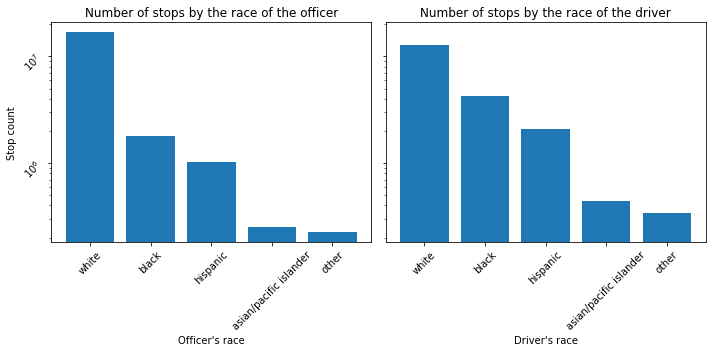

In [10]:
stat = stat.sort_values(by=['stop_count'], ignore_index=True, ascending=False)
# Plot number of stops performed by each officer race
df = stat.query("officer_race!='all' and subject_race=='all'")
# Plot number of stops on each subject_race
df2 = stat.query("officer_race=='all' and subject_race!='all'")

fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)

axes[0].bar(df['officer_race'], df['stop_count'], log=True)
axes[1].bar(df2['subject_race'], df2['stop_count'], log=True)

# Format
axes[0].set_ylabel('Stop count')
axes[0].set_xlabel("Officer's race")
axes[0].set_title('Number of stops by the race of the officer')
axes[0].tick_params(labelrotation=45)

axes[1].set_xlabel("Driver's race")
axes[1].set_title('Number of stops by the race of the driver')
axes[1].tick_params(labelrotation=45)

fig.tight_layout()

### b) Proportion of stops by officer race

In [11]:
stat.head(10)

,officer_race,subject_race,stop_count,proportions
0,all,all,20070998,1.000000
1,white,all,16804695,1.000000
2,all,white,12927549,0.644091
3,white,white,11232935,0.668440
4,white,opposite,5571760,0.331560
5,all,black,4295970,0.214039
6,white,black,3471998,0.206609
7,all,hispanic,2065048,0.102887
8,black,all,1773874,1.000000
9,white,hispanic,1468594,0.087392


In [12]:
# Need a second list for the distribution plot
races_bis = ['white', 'black', 'hispanic', 'asian/pacific islander', 'other']
races_bis.reverse()

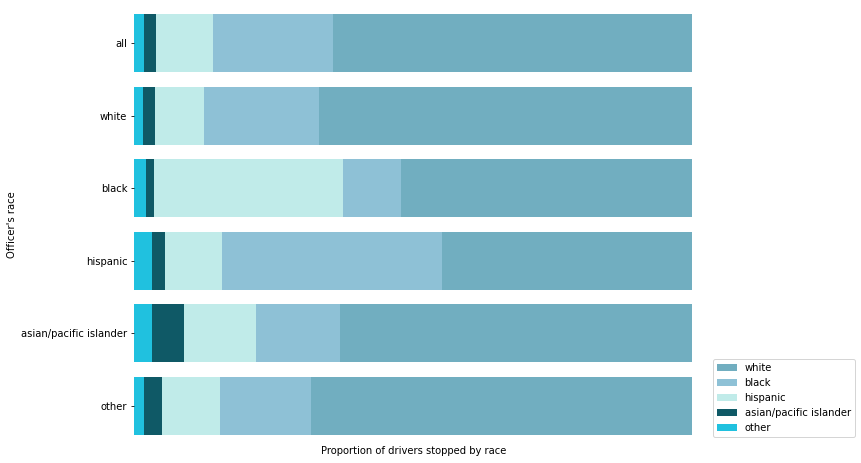

In [13]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Params for the plot aspect
codes = ['deep', 'muted', 'pastel', 'dark', 'bright']
colors = ['b', 'k', 'r', 'c', 'm', 'y']

# Compute the length of the bars for each race
for race in races:
    sums = 0
    for race_rev in races_bis:
        stat.loc[(stat['officer_race']==race) 
                  & (stat['subject_race']==race_rev), 'prop'] = stat.loc[(stat['officer_race']==race) 
                                                                           & (stat['subject_race']==race_rev), 'proportions'] + sums
        sums += stat.loc[(stat['officer_race']==race) & (stat['subject_race']==race_rev), 'proportions'].to_numpy()[0]

races.remove('all')

# Plot the barplot
for i in range(len(races)):
    sns.set_color_codes(codes[i]) # Either cycle through codes or colors to have different colors
    df = stat[stat['subject_race']==races[i]]
    sns.barplot(x="prop", y="officer_race", data=df,label=races[i], color='c')
    
    #for i, v in enumerate(dat['proportions']):
        #ax.text(dat.iloc[i,4], i-0.45, str(round(v,2)), color='blue')
    
# Add a legend and informative axis label
ax.legend(loc="lower right", frameon=True, bbox_to_anchor=(1.3, 0))
ax.set(xlim=(0, 1), ylabel="Officer's race", xlabel="Proportion of drivers stopped by race", xticks=[])
sns.despine(left=True, bottom=True)

# 2. Search rates based on race

## 2.1 Data processing

Only keep the data we need for this part:

In [14]:
data_search =  data[['county_name', 'state', 'subject_race', 'officer_race', 'search_conducted']]
data_search = data_search.dropna()

In [15]:
data_search.head(10)

,county_name,state,subject_race,officer_race,search_conducted
0,Walla Walla County,WA,white,white,False
1,King County,WA,black,white,False
2,Kittitas County,WA,white,white,False
3,Clark County,WA,white,white,False
4,Kitsap County,WA,white,white,False
5,Skagit County,WA,white,white,False
6,Pierce County,WA,black,white,False
7,King County,WA,white,black,True
8,Grays Harbor County,WA,white,white,False
11,Skagit County,WA,white,white,False


### a) Compute search rates by county for each subject race

In [16]:
# Compute rate (either hit rate or search rate) of given variable
def computeRate(data, variable, column_names):
    rates = pd.DataFrame(columns=column_names)
    group = data.groupby(['county_name', 'state', 'subject_race'])
    
    for idx, df in group:
        if variable == 'contraband_found':
            total = df[df['search_conducted']==True].shape[0]
        else :
            total = df.shape[0]
        positive = df.loc[df[variable]==True].shape[0]
        if total != 0:
            temp = pd.DataFrame([[idx[0], idx[1], idx[2], (positive/total), positive, total]], columns=rates.columns)
            rates = pd.concat([rates, temp], axis=0, ignore_index=True)
        
    return rates

In [17]:
column_names=['county_name', 'state', 'subject_race', 'search_rate', 'count_searched', 'total_stops']
rates = computeRate(data_search, 'search_conducted', column_names)
# Save data
rates.to_csv(r'data/search_rates.csv', index=False)
rates.head(10)

,county_name,state,subject_race,search_rate,count_searched,total_stops
0,Abbeville County,SC,black,0.026355,371,14077
1,Abbeville County,SC,hispanic,0.069355,43,620
2,Abbeville County,SC,other,0.000000,0,243
3,Abbeville County,SC,white,0.016999,433,25472
4,Adams County,WA,asian/pacific islander,0.013950,41,2939
5,Adams County,WA,black,0.038708,121,3126
6,Adams County,WA,hispanic,0.029374,272,9260
7,Adams County,WA,other,0.032220,27,838
8,Adams County,WA,white,0.014826,1011,68191
9,Aiken County,SC,black,0.035759,3707,103665


### b) Compute search rates for subjects of same & different race than that of the officer

In [38]:
# Compute rate for variable for subject of same/different race than officer's race
def computeRateRace(data, togroup, variable, column_names):
    stats = pd.DataFrame(columns=column_names)
    group = togroup.groupby(['county_name', 'state', 'officer_race'])

    for idx, df in group:
        data_same = data.loc[(data['county_name']==idx[0]) & (data['state']==idx[1])
                             & (data['subject_race']==idx[2])]
        rate_same = data_same[variable].to_numpy(dtype=np.float64)
        
        if rate_same.size > 0: # Some counties don't have data for some races
            data_diff = data.loc[(data['county_name']==idx[0]) & (data['state']==idx[1])
                            & (data['subject_race']!=idx[2])]
            diff = data_diff[data.columns.tolist()[-2]].sum()
            diff_tot = data_diff[data.columns.tolist()[-1]].sum()
            
            rate_diff = np.nan
            if diff_tot != 0: # Avoid division by 0
                rate_diff = diff / diff_tot
            temp = pd.DataFrame([[idx[0], idx[1], idx[2], True, rate_same[0],
                                  data_same[data.columns.tolist()[-2]].sum(), data_same[data.columns.tolist()[-1]].sum()],
                            [idx[0], idx[1], idx[2], False, rate_diff, diff, diff_tot]], columns=stats.columns)
            stats = pd.concat([stats, temp], axis=0, ignore_index=True)
        
    return stats

In [39]:
column_names = ['county_name', 'state', 'officer_race', 'same_race_officer', 'search_rate', 'count_searched', 'total_stops']
stats_search = computeRateRace(rates, data_search,'search_rate', column_names)
stats_search.head(10)

,county_name,state,officer_race,same_race_officer,search_rate,count_searched,total_stops
0,Abbeville County,SC,black,True,0.026355,371,14077
1,Abbeville County,SC,black,False,0.018075,476,26335
2,Abbeville County,SC,hispanic,True,0.069355,43,620
3,Abbeville County,SC,hispanic,False,0.020205,804,39792
4,Abbeville County,SC,other,True,0.000000,0,243
5,Abbeville County,SC,other,False,0.021086,847,40169
6,Abbeville County,SC,white,True,0.016999,433,25472
7,Abbeville County,SC,white,False,0.027711,414,14940
8,Adams County,WA,asian/pacific islander,True,0.013950,41,2939
9,Adams County,WA,asian/pacific islander,False,0.017577,1431,81415


### c) Data visualization

In [59]:
# Plots the scatter plot
# Factor is used to scale the area
def plotScatter(ax, df, variable, race, factor):
    mask= "officer_race=='"+race+"'"
    same = df.query(mask+" and same_race_officer==True")
    diff = df.query(mask+" and same_race_officer==False")
    area = same[df.columns.tolist()[-2]].to_numpy(dtype=np.float64) + diff[df.columns.tolist()[-2]].to_numpy(dtype=np.float64)
    ax.scatter(same[variable] * 100, diff[variable] * 100, marker='o', color='None', alpha=1, edgecolor='k', linewidth=0.5, s=area * factor)
    
    # Add the line y=x
    lim = df.query(mask)[variable].max() * 100
    x = np.linspace(0,lim)
    ax.plot(x, x, ls='--', color='k', alpha=0.7)
    ax.set_xlabel(race+' officer and '+race+' driver')
    ax.set_ylabel(race+' officer and non '+race+' driver')

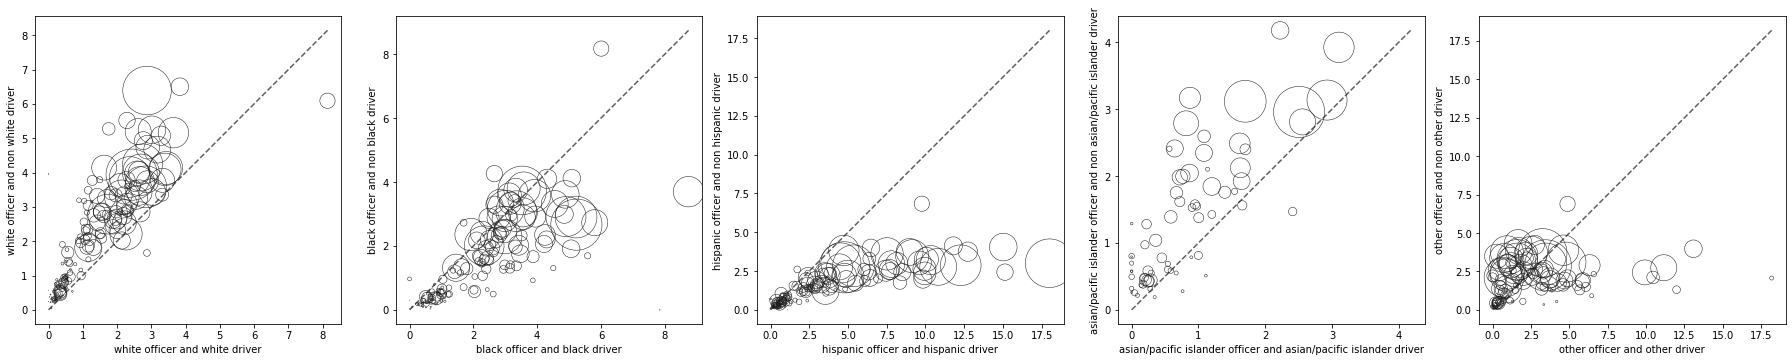

In [60]:
fig, axes = plt.subplots(1, 5, figsize=(25,5))

for i in range(len(races)):    
    plotScatter(axes[i], stats_search, 'search_rate', races[i], 0.1)
    
fig.tight_layout()

### d) Confidence intervals

In [48]:
# Input: your array and the number of random samples (e.g., 1000 is a good number)
# Output: [lower error, upper error]

def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [49]:
def computeCI(data, variable):
    ci = pd.DataFrame(columns=['officer_race', 'same_race_officer', 'lower_error', 'mean', 'upper_error'])

    for race in races:
        temp_same = data[(data['officer_race']==race) & data['same_race_officer']==True][variable]
        ci_temp_same = bootstrap_CI(temp_same, 1000)
        temp_diff = data[(data['officer_race']==race) & data['same_race_officer']==False][variable]
        ci_temp_diff = bootstrap_CI(temp_diff, 1000)
        temp = pd.DataFrame([[race, True, ci_temp_same[0], temp_same.mean(), ci_temp_same[1]],
                            [race, False, ci_temp_diff[0], temp_diff.mean(), ci_temp_diff[1]]], columns=ci.columns)
        ci = pd.concat([ci, temp], ignore_index=True)
    return ci

In [50]:
ci_search = computeCI(stats_search, 'search_rate')
ci_search.head(10)

,officer_race,same_race_officer,lower_error,mean,upper_error
0,white,True,0.011869,0.013663,0.015522
1,white,False,0.019817,0.021056,0.022326
2,black,True,0.020088,0.022839,0.025639
3,black,False,0.018481,0.019745,0.021125
4,hispanic,True,0.030076,0.036337,0.043062
5,hispanic,False,0.017150,0.018093,0.019093
6,asian/pacific islander,True,0.006608,0.008287,0.010142
7,asian/pacific islander,False,0.019634,0.020805,0.022054
8,other,True,0.021116,0.026531,0.033011
9,other,False,0.018280,0.019474,0.020456


# 3. Hit rates based on race

Only keep the data we need for this part:

In [51]:
data_hit = data[['county_name', 'state', 'subject_race', 'officer_race', 'search_conducted', 'contraband_found']]
data_hit = data_hit.dropna()

### a) Compute hit rates by county for each subject race

In [52]:
column_names=['county_name', 'state', 'subject_race', 'hit_rate', 'count_contraband', 'total_searches']
hit = computeRate(data_hit, 'contraband_found', column_names)

# Save data
hit.to_csv(r'data/hit_rates.csv', index=False)
hit.head(10)

,county_name,state,subject_race,hit_rate,count_contraband,total_searches
0,Abbeville County,SC,black,0.412399,153,371
1,Abbeville County,SC,hispanic,0.093023,4,43
2,Abbeville County,SC,white,0.411085,178,433
3,Adams County,WA,asian/pacific islander,0.365854,15,41
4,Adams County,WA,black,0.330579,40,121
5,Adams County,WA,hispanic,0.172794,47,272
6,Adams County,WA,other,0.259259,7,27
7,Adams County,WA,white,0.348170,352,1011
8,Aiken County,SC,black,0.344483,1277,3707
9,Aiken County,SC,hispanic,0.157461,191,1213


### b) Compute hit rates for subjects of same & different race than that of the officer

In [54]:
column_names = ['county_name', 'state', 'officer_race', 'same_race_officer', 'hit_rate', 'count_contraband', 'total_searches']
stats_hit = computeRateRace(hit, data_hit,'hit_rate', column_names)
stats_hit.head(10)

,county_name,state,officer_race,same_race_officer,hit_rate,count_contraband,total_searches
0,Abbeville County,SC,black,True,0.412399,153,371
1,Abbeville County,SC,black,False,0.382353,182,476
2,Abbeville County,SC,white,True,0.411085,178,433
3,Abbeville County,SC,white,False,0.379227,157,414
4,Adams County,WA,hispanic,True,0.172794,47,272
5,Adams County,WA,hispanic,False,0.345000,414,1200
6,Adams County,WA,other,True,0.259259,7,27
7,Adams County,WA,other,False,0.314187,454,1445
8,Adams County,WA,white,True,0.348170,352,1011
9,Adams County,WA,white,False,0.236443,109,461


### c) Data visualization

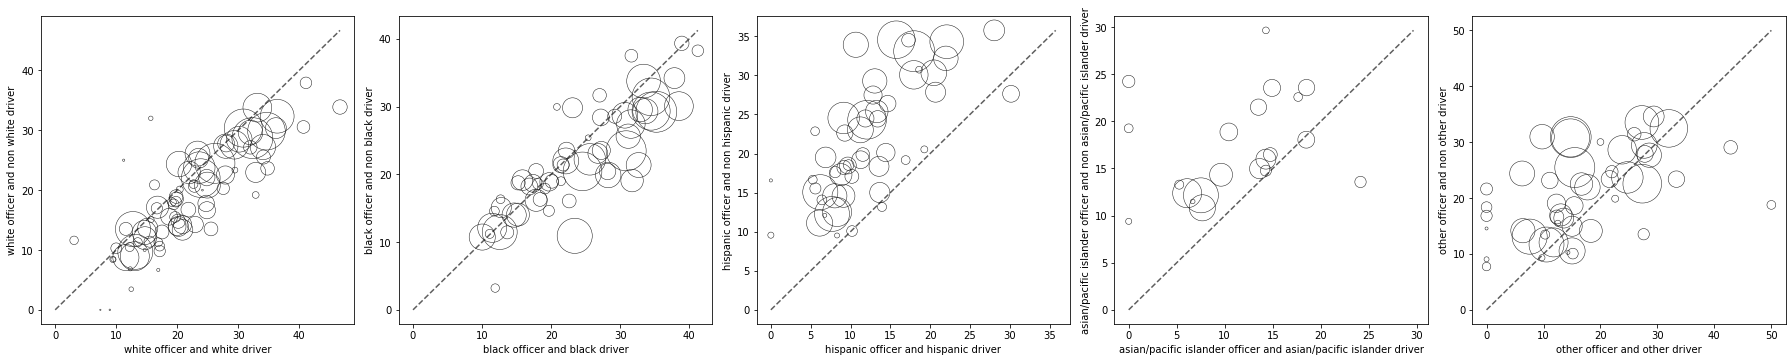

In [62]:
fig, axes = plt.subplots(1, 5, figsize=(25,5))

for i in range(len(races)):    
    plotScatter(axes[i], stats_hit, 'hit_rate',races[i], 0.4)
    
fig.tight_layout()

### d) Confidence intervals

In [63]:
ci_hit = computeCI(stats_hit, 'hit_rate')
ci_hit.head(10)

,officer_race,same_race_officer,lower_error,mean,upper_error
0,white,True,0.200761,0.219042,0.238787
1,white,False,0.181833,0.189545,0.197960
2,black,True,0.217703,0.237769,0.259547
3,black,False,0.181229,0.188765,0.196590
4,hispanic,True,0.105922,0.121757,0.138429
5,hispanic,False,0.194553,0.202103,0.210555
6,asian/pacific islander,True,0.083073,0.110346,0.137192
7,asian/pacific islander,False,0.190139,0.197680,0.204979
8,other,True,0.140349,0.170223,0.200239
9,other,False,0.189319,0.196665,0.204306


### c) Student t-test

In [64]:
def ttest(data, races):
    df = pd.DataFrame(columns=['officer_race', 'mean_same_race', 'mean_diff_race', 't-statistic', 'p-value'])
    for race in races:
        same_race = data[(data['officer_race']==race) & (data['same_race_officer']==True)]['hit_rate']
        diff_race = data[(data['officer_race']==race) & (data['same_race_officer']==False)]['hit_rate']
        result = stats.ttest_ind(same_race, diff_race)
        temp = pd.DataFrame([[race, same_race.mean(), diff_race.mean(), result[0], result[1]]], columns=df.columns)
        df = pd.concat([df, temp], ignore_index=True)
    return df

In [65]:
ttest_hit = ttest(stats_hit, races)
ttest_hit.head(10)

,officer_race,mean_same_race,mean_diff_race,t-statistic,p-value
0,white,0.219042,0.186801,2.485548,1.392540e-02
1,black,0.237769,0.219656,1.228504,2.217443e-01
2,hispanic,0.121757,0.214610,-6.915887,4.160771e-10
3,asian/pacific islander,0.110346,0.171902,-3.321728,1.918584e-03
4,other,0.170223,0.206091,-1.881738,6.290119e-02
